# Using LSPE in a Toy Molecular Screening Campaign with Human Feedback

This notebook illustrates a use-case for LSPE in the screening of molecules based on their hydration free energy using simulated binary feedback from a human research chemist. The dataset used is from [1] and the code for the molecular GP kernels is from [2].

In [13]:
"""Imports """

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

import sys
sys.path.append('..')

import time
from itertools import combinations

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from mordred import Calculator, descriptors
from rdkit import Chem

from botorch import fit_gpytorch_model
from botorch.acquisition import GenericMCObjective, LearnedObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement, qSimpleRegret
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.models.deterministic import FixedSingleSampleModel
from botorch.models import SingleTaskGP
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.mlls import ExactMarginalLogLikelihood

from molecule_utilities.dataloader import DataLoaderMP
from molecule_utilities.dataloader.data_utils import transform_data
from molecule_utilities.kernels.tanimoto_kernel import TanimotoKernel

In [15]:
"""Utility functions for generating ground truth preference data simulated from a research chemist."""

def generate_initial_comparisons(y, n_comp, replace=False):
    """Create noiseless pairwise comparisons with noise assuming y is 1d. This function is used to 
       generate initial comparisons only.
    
    Args:
        y: 1D Tensor of ground truth utilities (labels)
        n_comp: Int specifying the number of initial pairwise comparisons
        replace: Bool indicating whether to generate comparisons with replacement
        
    Returns:
        comp_pairs: NumPy array of pairwise prefernces
    """
    
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[np.random.choice(range(len(all_pairs)), n_comp, replace=replace)]
    c0 = y[comp_pairs[:, 0]]
    c1 = y[comp_pairs[:, 1]]
    reverse_comp = (c0 < c1)
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs

def generate_comparisons(util):
    """Given an 1-d tensor of utility, create pairwise comparisons between adjacent items. This function
       is used only within the Bayesian optimization loop (i.e. not for intialization).
    
    Args:
        util: 1D Tensor of ground truth utilities (labels)
        
    Returns:
        comp_pairs: NumPy array of pairwise preferences
    """
    
    util = util.reshape(-1, 2)
    comp_pairs = torch.arange(util.numel()).reshape(-1, 2)
    flip = util[:, 0] < util[:, 1]
    comp_pairs[flip, [0]], comp_pairs[flip, [1]] = comp_pairs[flip, [1]], comp_pairs[flip, [0]]

    return comp_pairs


In [16]:
def update_random_observations(best_random, heldout_inputs, heldout_outputs):
    """
    Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point from the heldout set, observing its value, and updating the list.

    Args:
        best_random: List of best random values observed so far
        heldout_inputs: Tensor of inputs
        heldout_outputs: Tensor of output values

    Returns: best_random, float specifying the objective function value.
    """

    # Take a random sample by permuting the indices and selecting the first element.
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)

    return best_random, heldout_inputs, heldout_outputs

To featurize the molecules in the FreeSolv dataset we use Mordred descriptors [3], which are high-dimensional continuous vectors.

In [56]:
"""Mordred descriptor computation is expensive"""

# Load the Photoswitch dataset
loader = DataLoaderMP()
loader.load_benchmark("FreeSolv", "molecule_utilities/dataset/Freesolv.csv")
subsample=100 # subsample dataset for speed
# y = loader.labels[0:subsample]
y = loader.labels

calc = Calculator(descriptors, ignore_3D=True)
# mols = [Chem.MolFromSmiles(smi) for smi in loader.features[0:subsample]] #subsample for speed
mols = [Chem.MolFromSmiles(smi) for smi in loader.features] #subsample for speed
t0 = time.time()
X = [calc(mol) for mol in mols]
t1 = time.time()
print(f'Mordred descriptor computation takes {t1 - t0} seconds')
X = np.array(X).astype(np.float64)

Mordred descriptor computation takes 270.91417813301086 seconds


In the BOPE setting we assume that we map an input space to a high-dimensional outcome space. In this instance we choose our input space $\mathbf{x}$ to be fragprints, a concatenated vector of ECFP fingerprints and RDKit fragment features. Our outcome space $y$ is then the Mordred descriptor vector and our utility $g(y)$ is the hydration free energy of the molecule.

In [57]:
"""Fragprint descriptor computation"""

loader.featurize('fragprints')
# X_frag = loader.features[0:subsample]
X_frag = loader.features

We preprocess the Mordred descriptors to remove NaN features and features that have a variance threshold smaller than 0.05 post-standardization.

In [58]:
"""Collect nan indices"""

nan_dims = []

for i in range(len(X)):
    nan_indices = list(np.where(np.isnan(X[i, :]))[0])
    for dim in nan_indices:
        if dim not in nan_dims:
            nan_dims.append(dim)
            
X_mordred_nonan = np.delete(X, nan_dims, axis=1)

# Remove variables with near-constant variance
variance_threshold = 0.05
selector = VarianceThreshold(variance_threshold)
X_rem = selector.fit_transform(X_mordred_nonan)

# Store values for BayesOpt
y_bo = X_rem

# Compute outcome space dimensionality
outcome_dim = X_rem.shape[-1]

In [59]:
"""BOPE specific utilities"""

def fit_outcome_model(X, Y):
    """Fit the outcome model f(x). We use a Tanimoto kernel to operate on the
       fragprints representation.
    
    Args:
        X: Tensor of fragprints representation
        Y: Tensor of PCA-reduced Mordred descriptors
        
    Returns:
        GP model instance for the outcome model f(x)
    """
    outcome_model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        outcome_transform=Standardize(m=Y.shape[-1]),
        covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel()),
    )
    mll = ExactMarginalLogLikelihood(outcome_model.likelihood, outcome_model)
    fit_gpytorch_model(mll)
    return outcome_model


def fit_pref_model(Y, comps):
    """Fit the preference model g(y).
    
    Args:
        Y: Tensor of PCA-reduced Mordred descriptors
        comps: Tensor of pairwise comparisons
        
    Returns:
        model: GP model instance for the preference function g(y)
    
    """
    model = PairwiseGP(Y, comps)
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model


def run_pref_learn(outcome_model, train_Y, train_comps, n_comps, heldout_inputs, heldout_outputs, previous_winner,
                  previous_winner_util):
    """Perform preference exploration for n_comps rounds.
    
    Args:
        outcome_model: GP model instance for f(x)
        train_Y: Tensor of PCA-reduced Mordred descriptors
        train_comps: Tensor of pairwise comparisons
        n_comps: Int specifying the number of comparisons to generate in the preference exploration stage
        heldout_inputs: updated heldout set of molecules in their fragprints representation x
        heldout_outputs: updated heldout set of true molecule utilities (labels)
        previous_winner: the x-value of the selected point on the previous iteration of BO
        previous_winner_util: the true utilty g(y) of the previously selected point.
        
    Returns:
        train_Y: updated training set of PCA-reduced outcomes
        train_comps: updated set of pairwise comparisons
    """
    
    for i in range(n_comps):
        
        pref_model = fit_pref_model(train_Y, train_comps)
        
        # EUBO-zeta
        one_sample_outcome_model = FixedSingleSampleModel(model=outcome_model)
        
        acqf = AnalyticExpectedUtilityOfBestOption(
            pref_model=pref_model, 
            outcome_model=one_sample_outcome_model, 
            previous_winner=previous_winner
        )
        
        # Loop over the discrete set of points to evaluate the acquisition function at.
        acq_vals = []
        for i in range(len(heldout_outputs)):
            acq_vals.append(acqf(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

        # observe new values
        acq_vals = torch.tensor(acq_vals)
        best_idx = torch.argmax(acq_vals)
        cand_X = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
        new_util = heldout_outputs[best_idx].unsqueeze(-1)
        
        cand_Y = one_sample_outcome_model(cand_X)
        cand_Y = cand_Y.detach().clone()
        cand_comps = generate_comparisons(torch.cat((previous_winner_util, new_util)).squeeze(-1))

        train_comps = torch.cat((train_comps, cand_comps))
        train_Y = torch.cat((train_Y, cand_Y))

    return train_Y, train_comps


def gen_exp_cand(outcome_model, objective, q, heldout_inputs, heldout_outputs, heldout_ys):
    """Given an outcome model and an objective, generate q experimental candidates
    using specified acquisition function.
    
    Args:
        outcome_model: GP model instance of f(x)
        objective: objective given by the preference model g(y)
        q: Int specifying the batch size
        heldout_inputs: heldout set of molecules in their fragprints representation x
        heldout_outputs: heldout set of true molecule utilities (labels)
        heldout_ys: heldout set of Mordred descriptors for molecules
        
    Returns:
        cand_X: The new input to query (heldout molecule)
        new_util: The utility (label) of said molecule
        heldout_inputs: updated heldout set of molecules in their fragprints representation x
        heldout_outputs: updated heldout set of true molecule utilities (labels)
        new_y: New Mordred representation for the selected molecule
        heldout_ys: updated heldout set of Mordred representation
    """
    # generate experimental candidates with qNEI/qNEIUU
    acq_func = qNoisyExpectedImprovement(
        model=outcome_model,
        objective=objective,
        X_baseline=outcome_model.train_inputs[0][0, :], # TODO: Improve me
        prune_baseline=True,
    )
    
    # Loop over the discrete set of points to evaluate the acquisition function at.
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

    # observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    cand_X = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
    new_util = heldout_outputs[best_idx].unsqueeze(-1)  # add output dimension
    new_y = heldout_ys[best_idx].unsqueeze(-2)  # add batch dimension

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)
    heldout_ys = torch.cat((heldout_ys[:best_idx], heldout_ys[best_idx+1:]), axis=0)

    return cand_X, new_util, heldout_inputs, heldout_outputs, new_y, heldout_ys

In [60]:
"""Bayesian optimisation loop comparing LSPE-PCA, LSPE-REMBO and random search"""

N_TRIALS = 30
holdout_set_size = 0.85
n_components = 5
N_ITERS = 20
m = 300 # Initial comparisons
n_comps = 1 # comparisons per iteration
NUM_OUTCOME_SAMPLES = 64

# precompute random projection matrix and its inverse for REMBO

A = torch.randn((outcome_dim, n_components)).numpy().astype(np.float64)
# A_inv = torch.pinverse(A) - inverse not needed

best_observed_all_eubo, best_observed_all_rembo, best_random_all = [], [], []

# average over multiple random trials (each trial splits the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):
    
    # Experimentation stage: initial exploration batch
    torch.manual_seed(trial+20)
    np.random.seed(trial+20)

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_eubo, best_observed_rembo, best_random = [], [], []
    
    # Generate initial outcome data and initialize model
    train_x_eubo, heldout_x_eubo, train_y_eubo, heldout_y_eubo = train_test_split(X_frag, y_bo, test_size=holdout_set_size, random_state=trial)
    train_x_rembo, heldout_x_rembo, train_y_rembo, heldout_y_rembo = train_x_eubo, heldout_x_eubo, train_y_eubo, heldout_y_eubo
    # Generate the true utility values using the same split
    _, _, train_utils, heldout_utils = train_test_split(X_frag, y, test_size=holdout_set_size, random_state=trial)
    train_utils_rembo, heldout_utils_rembo = train_utils, heldout_utils
        
    # Apply PCA to the outcomes
    scaler = StandardScaler()
    train_y_eubo_pca = scaler.fit_transform(train_y_eubo)
    heldout_y_eubo_pca = scaler.transform(heldout_y_eubo)
    pca_mordred = PCA(n_components=n_components)
    train_y_eubo_pca = pca_mordred.fit_transform(train_y_eubo_pca)
    heldout_y_eubo_pca = pca_mordred.transform(heldout_y_eubo_pca)    
    best_observed_value_eubo = torch.tensor(np.max(train_utils))
    
    # Apply random embedding to the outcomes
    scaler_rembo = StandardScaler()
    train_y_rembo_emb = scaler_rembo.fit_transform(train_y_rembo)
    heldout_y_rembo_emb = scaler_rembo.transform(heldout_y_rembo)
    train_y_rembo_emb = train_y_rembo_emb@A
    heldout_y_rembo_emb = heldout_y_rembo_emb@A
    best_observed_value_rembo = torch.tensor(np.max(train_utils_rembo))
        
    # Set the previous winner for the first round
    previous_winner = torch.tensor(train_y_eubo_pca[np.argmax(train_utils)]).unsqueeze(-2)
    previous_winner_util = torch.tensor(np.max(train_utils)).unsqueeze(-1).unsqueeze(-1)
    
    # Set the previous winner for rembo
    previous_winner_rembo = previous_winner
    previous_winner_util_rembo = previous_winner_util

    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_x_eubo = torch.tensor(train_x_eubo.astype(np.float64))
    heldout_x_eubo = torch.tensor(heldout_x_eubo.astype(np.float64))
    train_y_eubo_pca = torch.tensor(train_y_eubo_pca.astype(np.float64))
    heldout_y_eubo_pca = torch.tensor(heldout_y_eubo_pca.astype(np.float64))
    train_utils = torch.tensor(train_utils)
    heldout_utils = torch.tensor(heldout_utils)
    train_y_eubo = torch.tensor(train_y_eubo)
    heldout_y_eubo = torch.tensor(heldout_y_eubo)
    
    train_x_rembo = torch.tensor(train_x_rembo.astype(np.float64))
    heldout_x_rembo = torch.tensor(heldout_x_rembo.astype(np.float64))
    train_y_rembo_emb = torch.tensor(train_y_rembo_emb.astype(np.float64))
    heldout_y_rembo_emb = torch.tensor(heldout_y_rembo_emb.astype(np.float64))
    train_utils_rembo = torch.tensor(train_utils_rembo)
    heldout_utils_rembo = torch.tensor(heldout_utils_rembo)
    train_y_rembo = torch.tensor(train_y_rembo)
    heldout_y_rembo = torch.tensor(heldout_y_rembo)
    
    # Generate initial comparisons
    train_comps = generate_initial_comparisons(train_utils.squeeze(-1), m)
    train_comps_rembo = train_comps

    # The initial heldout set is the same for random search and rembo
    heldout_x_random = heldout_x_eubo
    heldout_utils_random = heldout_utils
    
    # Initialize the outcome model for PCA
    outcome_model = fit_outcome_model(train_x_eubo, train_y_eubo_pca)
    
    # Initialize the outcome model for REMBO
    
    outcome_model_rembo = fit_outcome_model(train_x_rembo, train_y_rembo_emb)

    best_observed_eubo.append(best_observed_value_eubo)
    best_random.append(best_observed_value_eubo)
    best_observed_rembo.append(best_observed_value_rembo)

    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):
                                                    
        # Run preference exploration
        _, train_comps = run_pref_learn(outcome_model, train_y_eubo_pca, train_comps, n_comps, 
                                              heldout_x_eubo, heldout_utils, previous_winner,
                                              previous_winner_util)
        
        # Run preferece exploration for REMBO
        _, train_comps_rembo = run_pref_learn(outcome_model_rembo, train_y_rembo_emb, train_comps_rembo, n_comps, 
                                              heldout_x_rembo, heldout_utils_rembo, previous_winner_rembo,
                                              previous_winner_util_rembo)
                        
        # Run experimentation with the learned preference model and qNEIUU
        pref_model = fit_pref_model(train_y_eubo_pca, train_comps)
        pref_obj = LearnedObjective(pref_model=pref_model)
        new_x_eubo, new_util, heldout_x_eubo, heldout_utils, new_y_eubo, heldout_y_eubo = gen_exp_cand(outcome_model, pref_obj, q=1, 
                                                                           heldout_inputs=heldout_x_eubo, 
                                                                           heldout_outputs=heldout_utils,
                                                                           heldout_ys=heldout_y_eubo)
        
        # Run experimentation with the learned preference model for REMBO
        pref_model_rembo = fit_pref_model(train_y_rembo_emb, train_comps_rembo)
        pref_obj_rembo = LearnedObjective(pref_model=pref_model_rembo)
        new_x_rembo, new_util_rembo, heldout_x_rembo, heldout_utils_rembo, new_y_rembo, heldout_y_rembo = gen_exp_cand(outcome_model_rembo, pref_obj_rembo, q=1, 
                                                                           heldout_inputs=heldout_x_rembo, 
                                                                           heldout_outputs=heldout_utils_rembo,
                                                                           heldout_ys=heldout_y_rembo)
                        
        # update training points
        train_x_eubo = torch.cat([train_x_eubo, new_x_eubo])
        train_y_eubo = torch.cat([train_y_eubo, new_y_eubo])
        
        # Update training points for rembo
        train_x_rembo = torch.cat([train_x_rembo, new_x_rembo])
        train_y_rembo = torch.cat([train_y_rembo, new_y_rembo])
        
        # Re-apply PCA to the outcomes
        scaler = StandardScaler()
        train_y_eubo_pca = scaler.fit_transform(train_y_eubo)
        heldout_y_eubo_pca = scaler.transform(heldout_y_eubo)
        pca_mordred = PCA(n_components=n_components)
        train_y_eubo_pca = torch.tensor(pca_mordred.fit_transform(train_y_eubo_pca))
        heldout_y_eubo_pca = torch.tensor(pca_mordred.transform(heldout_y_eubo_pca))    
        
        # Recompute random embedding
        scaler_rembo = StandardScaler()
        train_y_rembo_emb = scaler_rembo.fit_transform(train_y_rembo)
        heldout_y_rembo_emb = scaler_rembo.transform(heldout_y_rembo)
        train_y_rembo_emb = train_y_rembo@A # typo, should be train_y_rembo_emb
        heldout_y_rembo_emb = heldout_y_rembo@A
        train_y_rembo_emb = torch.tensor(train_y_rembo_emb@A)
        heldout_y_rembo_emb = torch.tensor(heldout_y_rembo_emb@A)
        
        # update previous winners
        previous_winner = torch.tensor(pca_mordred.transform(scaler.transform(new_y_eubo)))
        previous_winner_util = new_util
        
        # update previous winners for REMBO
        previous_winner_rembo = torch.tensor(scaler_rembo.transform(new_y_rembo)@A)
        previous_winner_util_rembo = new_util_rembo
        
        # update random search progress
        best_random, heldout_x_random, heldout_utils_random = update_random_observations(best_random,
                                                                                     heldout_inputs=heldout_x_random,
                                                                                     heldout_outputs=heldout_utils_random)
        best_value_eubo = torch.max(new_util, best_observed_eubo[-1])
        best_observed_eubo.append(best_value_eubo)
        
        best_value_rembo = torch.max(new_util_rembo, best_observed_rembo[-1])
        best_observed_rembo.append(best_value_rembo)
        
        # reinitialize the outcome model so it is ready for fitting on the next iteration
        outcome_model = fit_outcome_model(train_x_eubo, train_y_eubo_pca)
        
        # reinitialize the outcome model for RemBO so it is ready for fitting on the next iteration
        outcome_model_rembo = fit_outcome_model(train_x_rembo, train_y_rembo_emb)
        
        print(".", end="")

    best_observed_all_eubo.append(best_observed_eubo)
    best_random_all.append(best_random)
    best_observed_all_rembo.append(best_observed_rembo)



Trial  1 of 30 ....................
Trial  2 of 30 ....................
Trial  3 of 30 ....................
Trial  4 of 30 ....................
Trial  5 of 30 ....................
Trial  6 of 30 ....................
Trial  7 of 30 ....................
Trial  8 of 30 ....................
Trial  9 of 30 ....................
Trial 10 of 30 ....................
Trial 11 of 30 ....................
Trial 12 of 30 ....................
Trial 13 of 30 ....................
Trial 14 of 30 ....................
Trial 15 of 30 ....................
Trial 16 of 30 ....................
Trial 17 of 30 ....................
Trial 18 of 30 ....................
Trial 19 of 30 ....................
Trial 20 of 30 ....................
Trial 21 of 30 ....................
Trial 22 of 30 ....................
Trial 23 of 30 ....................
Trial 24 of 30 ....................
Trial 25 of 30 ....................
Trial 26 of 30 ....................
Trial 27 of 30 ....................
Trial 28 of 30 ............

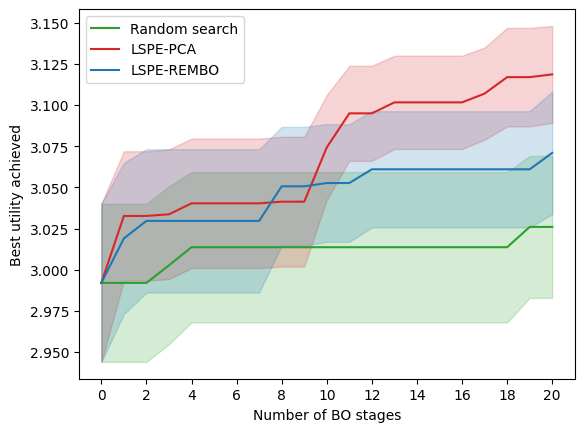

In [63]:
"""Plot the results"""

# Define a confidence interval function for plotting.
def ci(y):
    return 1.0 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)
y_eubo = torch.tensor(best_observed_all_eubo)
y_rembo = torch.tensor(best_observed_all_rembo)
y_rnd = torch.tensor(best_random_all)

y_rnd_mean = y_rnd.mean(axis=0)
y_eubo_mean = y_eubo.mean(axis=0)
y_rembo_mean = y_rembo.mean(axis=0)

lower_rnd = y_rnd_mean - ci(y_rnd)
upper_rnd = y_rnd_mean + ci(y_rnd)
lower_eubo = y_eubo_mean - ci(y_eubo)
upper_eubo = y_eubo_mean + ci(y_eubo)
lower_rembo = y_rembo_mean - ci(y_rembo)
upper_rembo = y_rembo_mean + ci(y_rembo)

plt.plot(iters, y_rnd_mean, label='Random search', color='tab:green')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2, color='tab:green')
plt.plot(iters, y_eubo_mean, label='LSPE-PCA', color='tab:red')
plt.fill_between(iters, lower_eubo, upper_eubo, alpha=0.2, color='tab:red')
plt.plot(iters, y_rembo_mean, label='LSPE-REMBO', color='tab:blue')
plt.fill_between(iters, lower_rembo, upper_rembo, alpha=0.2, color='tab:blue')
plt.xlabel('Number of BO stages')
plt.ylabel('Best utility achieved')
plt.legend(loc="upper left")
plt.xticks(list(np.arange(0, 21, 2)))
plt.show()

In [64]:
"""Optionall save values for replotting"""

save_for_replot = True

if save_for_replot:
    np.savetxt('y_eubo_freesolv.txt', y_eubo)
    np.savetxt('y_rnd_freesolv.txt', y_rnd)
    np.savetxt('y_rembo_freesolv.text', y_rembo)

## References

[1] Mobley, David L. (2013). [Experimental and Calculated Small Molecule Hydration Free Energies](http://www.escholarship.org/uc/item/6sd403pz). UC Irvine: Department of Pharmaceutical Sciences, UCI.

[2] Griffiths, R.R., Klarner, L., Moss, H.B., Ravuri, A., Truong, S., Rankovic, B., Du, Y., Jamasb, A., Schwartz, J., Tripp, A. and Kell, G. et al. 2022. [GAUCHE: A Library for Gaussian Processes in Chemistry](https://arxiv.org/abs/2212.04450). arXiv preprint arXiv:2212.04450.

[3] Moriwaki, H., Tian, Y.S., Kawashita, N. and Takagi, T., 2018. [Mordred: a molecular descriptor calculator](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y?ref=https://githubhelp.com). Journal of cheminformatics, 10(1), pp.1-14.